# Fix annotations - V3

In [1]:
import os,sys
import numpy as np 
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import anndata
import scipy
import matplotlib.pyplot as plt

In [2]:
import re

In [3]:
import scvelo as scv
import seaborn as sns

In [4]:
data_dir = '/nfs/team205/ed6/data/Fetal_immune/'
timestamp = '20210429'
marker_genes_dir = "/home/jovyan/mount/gdrive/Pan_fetal/significant_genes/marker genes/"

In [5]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/annotationsV2/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir
    scv.settings.figdir = figdir


In [6]:
def _load_split(split, min_n_cells = 50):
    spl_adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))
    spl_adata = spl_adata[~spl_adata.obs_names.isin(mat_barcodes)]
    
    ## Save annotations for split
    spl_adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[spl_adata.obs_names]["anno_lvl_2_final_clean"].astype("str")

    ## Label as OTHER cell labels that appear in less than 50 cells
    small_labels = spl_adata.obs["anno_lvl_2_final_clean"].value_counts()[spl_adata.obs["anno_lvl_2_final_clean"].value_counts() < min_n_cells].index
    spl_adata.obs.loc[spl_adata.obs["anno_lvl_2_final_clean"].isin(small_labels), "anno_lvl_2_final_clean"] = "OTHER"
    spl_adata.obs.loc[spl_adata.obs["anno_lvl_2_final_clean"]=="LOW_Q_INCONSISTENT", "anno_lvl_2_final_clean"] = "OTHER"
    return(spl_adata)

def _plot_marker_dotplot(spl_adata, mark_split, 
                         labels_order=None, 
                         gene_labels_order=None, 
                         unique_genes=False,
                         **kwargs):
    markers_df = all_markers_df[all_markers_df["split"].isin(mark_split)]
    markers_df = markers_df[markers_df.gene.isin(spl_adata.var_names)]
    # markers_df = markers_df.sort_values('anno_lvl_2')
    if gene_labels_order is None:
        gene_labels_order = markers_df.anno_lvl_2.unique().tolist()

    markers_df= markers_df[markers_df.anno_lvl_2.isin(gene_labels_order)]
    markers_dict = {g: d['gene'].values.tolist() for g, d in markers_df.groupby('anno_lvl_2')}
    markers_dict = {k: markers_dict[k] for k in gene_labels_order}
    
    if labels_order is None:
        labels_order = gene_labels_order
    
    keep_labels = [x for x in labels_order if x in spl_adata.obs["anno_lvl_2_final_clean"].values]
    
    if unique_genes:
        markers_ls_2 = sum(markers_dict.values(), [])
        markers_ls_ixs = np.unique(markers_ls_2, return_index=True)[1]
        markers_dict = [markers_ls_2[index] for index in sorted(markers_ls_ixs)]
    
    sc.pl.dotplot(spl_adata[spl_adata.obs["anno_lvl_2_final_clean"].isin(keep_labels)], 
                      markers_dict, 
                      groupby="anno_lvl_2_final_clean", 
                      categories_order=keep_labels, **kwargs)
        
        
def _plot_split_embedding(spl_adata, split, **kwargs):
    sns.set_context("talk")
    scv.pl.umap(spl_adata, color="anno_lvl_2_final_clean", legend_loc="on data", 
                size=2, legend_fontoutline=3,
                title=split, **kwargs)

In [7]:
def _save_plot_markers_embedding(spl_adata, mark_split, ncols=4, gene_labels_order = None):
    markers_df = all_markers_df[all_markers_df["split"].isin(mark_split)]
    markers_df = markers_df[markers_df.gene.isin(spl_adata.var_names)]
    # markers_df = markers_df.sort_values('anno_lvl_2')
    if gene_labels_order is None:
        gene_labels_order = markers_df.anno_lvl_2.unique().tolist()
    emb_figdir = "embedding_markers_{s}/".format(s=''.join(mark_split))
    if not os.path.exists(figdir + emb_figdir):
        os.mkdir(figdir + emb_figdir)
    scv.settings.figdir = figdir + emb_figdir

    for label in markers_df.anno_lvl_2.unique():
        markers_label_df = markers_df[markers_df.anno_lvl_2==label]
        sns.set_context("talk")
        marker_genes = markers_label_df.gene.tolist()
        scv.pl.umap(spl_adata, color=marker_genes, size=5, fontsize=32, legend_fontsize=32, ncols=ncols,
                    show=False,
                   save="embedding_markers_anno_lvl_2_{s}.{a}.png".format(s="".join(mark_split), a="_".join(label.split("/"))))
    scv.settings.figdir = figdir

## Build annotation file

Load annotation file curated by Chenqu/Isaac/Laura

In [199]:
anno_obs_new = pd.read_csv('/home/jovyan/mount/gdrive/Pan_fetal/meta_share/A4_V7_061021_full_Pan_immune_annotations_lvl2_V3.csv', index_col=0)

In [200]:
# Load old annotation file
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.clean.csv".format(t=timestamp), index_col=0)

In [126]:
# ## Save 4 legacy
# anno_obs.to_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.clean.V1.csv".format(t=timestamp))

In [201]:
anno_obs.anno_lvl_2_final_clean = anno_obs_new.anno_lvl_2_final_clean_v3.copy()

In [202]:
anno_obs = anno_obs[['n_counts', 'n_genes', 'file', 'mito', 'doublet_scores',
       'predicted_doublets', 'name', 'uniform_label',
       'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ',
       'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex',
       'Processing_method', 'AnnatomicalPart', 'Sample', 'anno_lvl_2_final_clean']]

In [203]:
anno_obs.anno_lvl_2_final_clean.value_counts(ascending=True)[0:50]

PRE_DC1                                     6
LMPP_ELP                                   11
ELP                                        25
ACTIVATED_DC1                              33
PLASMA_B                                   61
LC                                         66
CYCLING_MPP                               107
SKELETAL_MUSCLE                           123
PLACENTAL_CONTAMINANTS                    132
FIBROBLAST_CLUST53                        207
ENTEROENDOCRINE_CLUST52                   231
DOUBLET                                   232
PRE_DC2                                   253
CHONDROCYTE                               253
LOW_Q_INCONSISTENT                        261
AS_DC                                     269
MESENCHYMAL_LYMPHOID_TISSUE_ORGANISER     300
YS_STROMA                                 334
DOUBLET_ENDOTHELIUM_ERYTHROCYTE           340
CYCLING_MEMP                              382
INTERSTITIAL_CELLS_OF_CAJAL               409
MIGRATORY_DC                      

In [14]:
### Load reference data
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.h5ad'.format(t=timestamp))
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
## Load UMAP for full dataset
X_umap = np.load('/nfs/team205/ed6/data/Fetal_immune/scVI_outs/PAN.A01.v01.entire_data_raw_count.20210429.scVI_out.UMAP.npy')
adata.obsm["X_umap"] = X_umap

In [16]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])
adata = adata[~adata.obs_names.isin(mat_barcodes["x"])]

In [285]:
obs = adata.obs.copy()
obs["anno_lvl_2_final_clean"] = np.nan
obs.loc[anno_obs.index, "anno_lvl_2_final_clean"] = anno_obs.anno_lvl_2_final_clean

In [286]:
adata.obs = obs.copy()

In [206]:
adata = adata[~adata.obs.anno_lvl_2_final_clean.isna()].copy()

In [287]:
adata.obs['anno_lvl_2_final_clean'] = adata.obs['anno_lvl_2_final_clean'].astype("category")
adata.obs['anno_lvl_2_final_clean'] = adata.obs['anno_lvl_2_final_clean'].cat.rename_categories(obs['anno_lvl_2_final_clean'].astype("category").cat.categories)

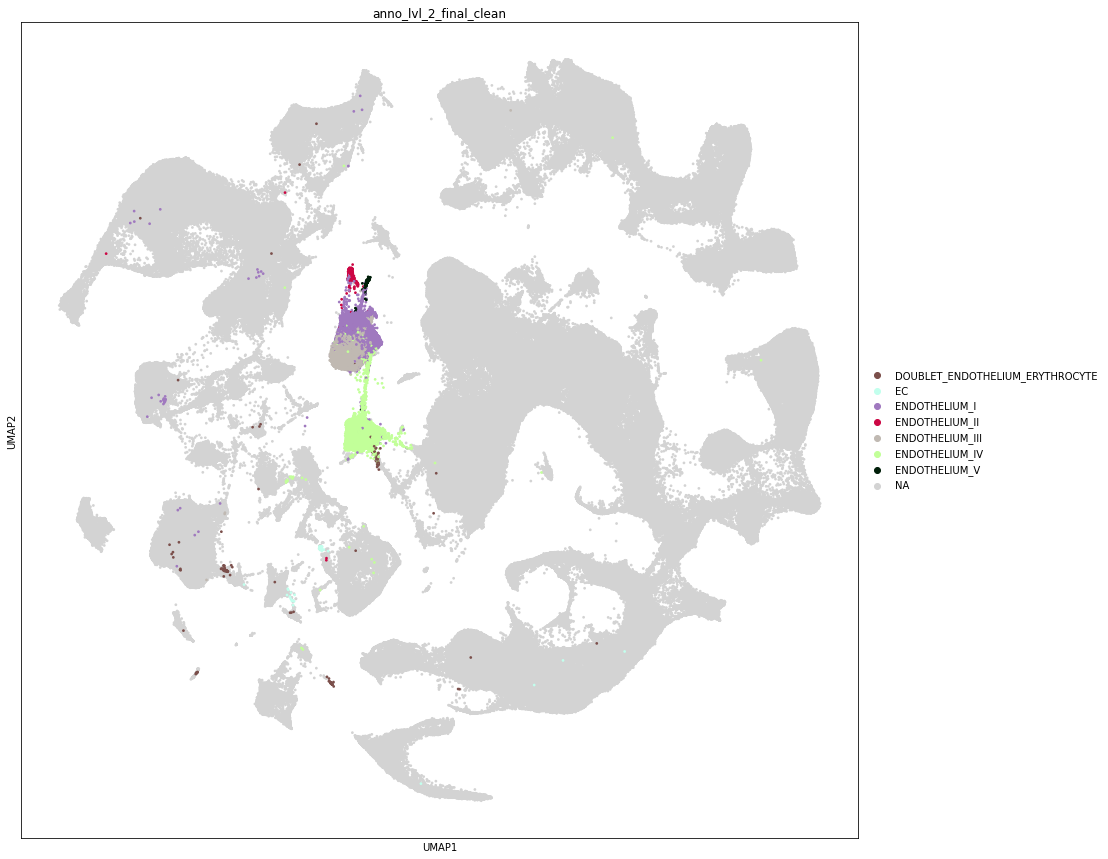

In [290]:
plt.rcParams['figure.figsize'] = [15,15]
sc.pl.umap(adata, color='anno_lvl_2_final_clean', palette=sc.plotting.palettes.default_102, groups=['EC']+[x for x in all_labels if "ENDOTHEL" in x], size=30)

In [252]:
all_labels = anno_obs.anno_lvl_2_final_clean.unique()

## rename stromal clusters
strom_df = pd.DataFrame([x for x in all_labels if "CLUST" in x])
strom_df.columns = ['old_name']
strom_df['class'] = [x.split("_CLUST")[0] for x in strom_df.old_name]
class_counts = strom_df.value_counts('class')

roman_no = dict(zip( range(0,11), ['I', "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X", "XI"]))

strom_df['new_name'] = np.nan
for cl in class_counts.index:
    nos = ["_"+roman_no[x] for x in range(class_counts[cl])]
    strom_df.loc[strom_df['class'] == cl, 'new_name'] = [a+b for a,b in zip(strom_df['class'][strom_df['class'] == cl],nos)]
    
rename_stromal = dict(zip(strom_df.old_name,strom_df.new_name))
anno_obs['anno_lvl_2_final_clean'] = [rename_stromal[x] if x in rename_stromal.keys() else x for x in anno_obs['anno_lvl_2_final_clean']]

In [256]:
## clean
clean = {
    'ELP':'LMPP_ELP',
    "FIBROBLAST":'FIBROBLAST_IV'
}

clean_anno = [clean[x] if x in clean.keys() else x for x in anno_obs.anno_lvl_2_final_clean]
clean_anno = ["_".join(x.split("/")) if "/" in x else x for x in clean_anno]
clean_anno = [re.split(" CELLS?$", x)[0] for x in clean_anno]
clean_anno = ["_".join(x.split(" ")) for x in clean_anno]
clean_anno = pd.Series(clean_anno)

anno_obs.anno_lvl_2_final_clean = clean_anno.values.copy()

#### Update groupings

In [ ]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

all_labels = anno_obs.anno_lvl_2_final_clean.unique()

missing_group = [x for x in all_labels if x not in anno_groups_dict_rev.keys()]
for k in missing_group:
    if "FIBROBLAST" in k or "ENDOTHEL" in k or "HEPATOCYTE" in k or "VSMC" in k or "EPITHELIUM" in k or "ENTEROENDOCRINE" in k:
        print(k)
        anno_groups_dict_rev[k] = "STROMA"
    else:
        anno_groups_dict_rev[k] = "MYELOID"

anno_groups_dict_rev = {k:v for k,v in anno_groups_dict_rev.items() if k in all_labels}

ks = list(set([x for x in anno_groups_dict_rev.values()]))
anno_groups_dict = {}
for k1 in ks:
    anno_groups_dict[k1] = [k for k,v in anno_groups_dict_rev.items() if anno_groups_dict_rev[k]==k1]

with open('../../metadata/anno_groups.json', 'w') as outfile:
    json.dump({k:list(v) for k,v in anno_groups_dict.items()}, outfile)

## Compare published VS new annotations

In [319]:
%load_ext rpy2.ipython

In [320]:
%%R
library(tidyverse)
library(ggplot2)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [321]:
reannotated_df = anno_obs[~anno_obs['uniform_label'].isna()]
annotations_conf_mat = sc.metrics.confusion_matrix("uniform_label", "anno_lvl_2_final_clean", reannotated_df, normalize=False)
anno_tot=sc.metrics.confusion_matrix("uniform_label", "anno_lvl_2_final_clean", anno_obs[~anno_obs['uniform_label'].isna()], normalize=False).sum(0)

In [322]:
# ## Group labels for plotting
# progenitors_labels = [x for x in reannotated_df.anno_lvl_0_final.unique() if x not in anno_vocabulary["anno_lvl_0"].unique() and x != "nan" and "T CELL" not in x]
# reannotated_df.loc[reannotated_df.anno_lvl_0_final.isin(progenitors_labels),'anno_lvl_0_final'] = "PROGENITORS"
# reannotated_df.loc[reannotated_df.anno_lvl_0_final.isin(['DN(P) T CELL', 'DN(early) T CELL']),'anno_lvl_0_final'] = "NK/T CELLS"

# anno_groups_dict = {}
# for s in reannotated_df["anno_lvl_0_final"].unique():
#     anno_groups_dict[s] = reannotated_df[reannotated_df["anno_lvl_0_final"] == s]["anno_lvl_2_final_clean"].unique()

In [323]:
def _plot_old_annotation_confusion(anno_group="B CELLS",
                                   min_cells = 5):
    keep_col = anno_groups_dict[anno_group]
    keep_row = annotations_conf_mat.index[np.any(annotations_conf_mat[anno_groups_dict[anno_group]] > min_cells, 1)]
    conf_mat = annotations_conf_mat.loc[keep_row, keep_col].T
    conf_mat = (conf_mat.T/conf_mat.sum(1)).T

    # row_order = conf_mat.max(1).sort_values(ascending=False).index
    row_order = conf_mat.index.sort_values()
    conf_mat = conf_mat.loc[row_order] ## Sort to have some sort of diagonal

    col_order = conf_mat.mean(0).sort_values(ascending=False).index
    conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal
    sns.heatmap(conf_mat,xticklabels=True, yticklabels=True)

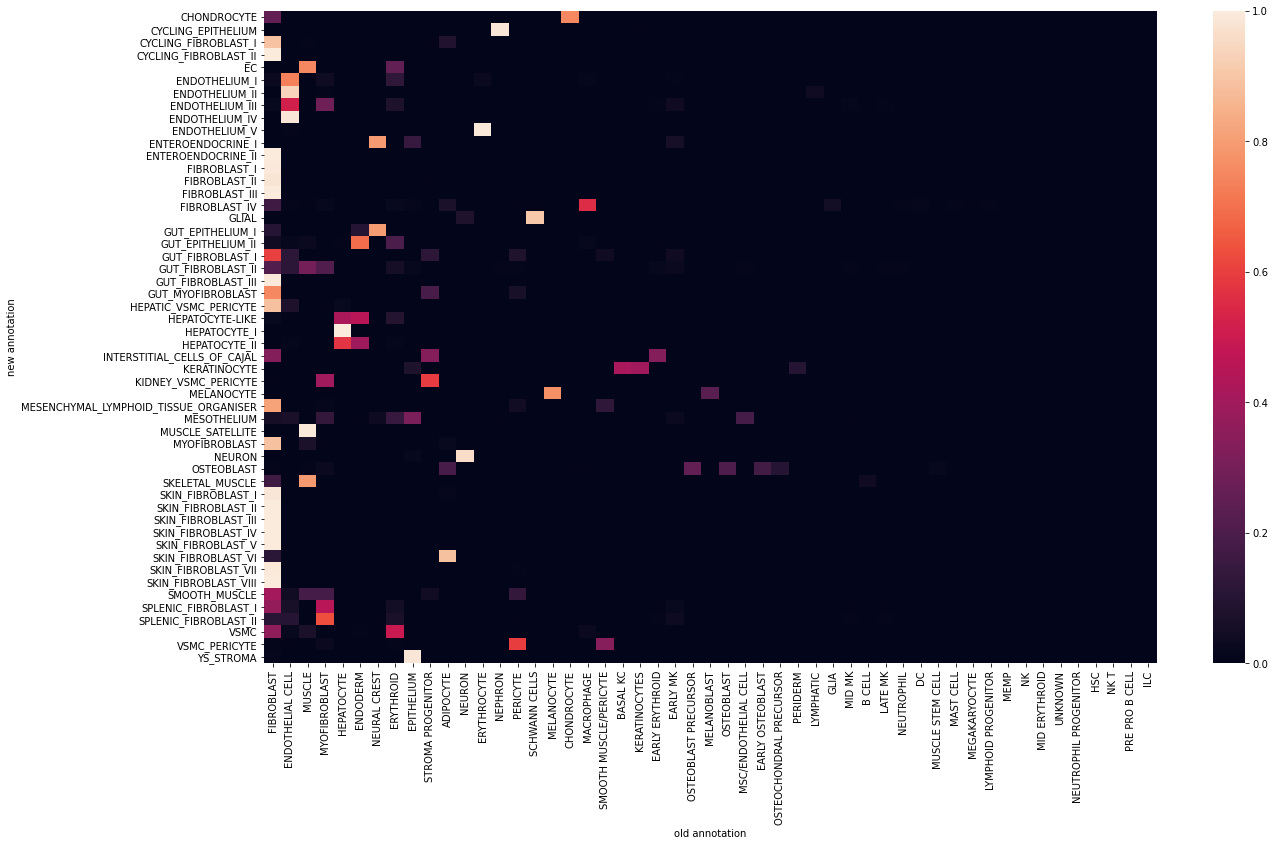

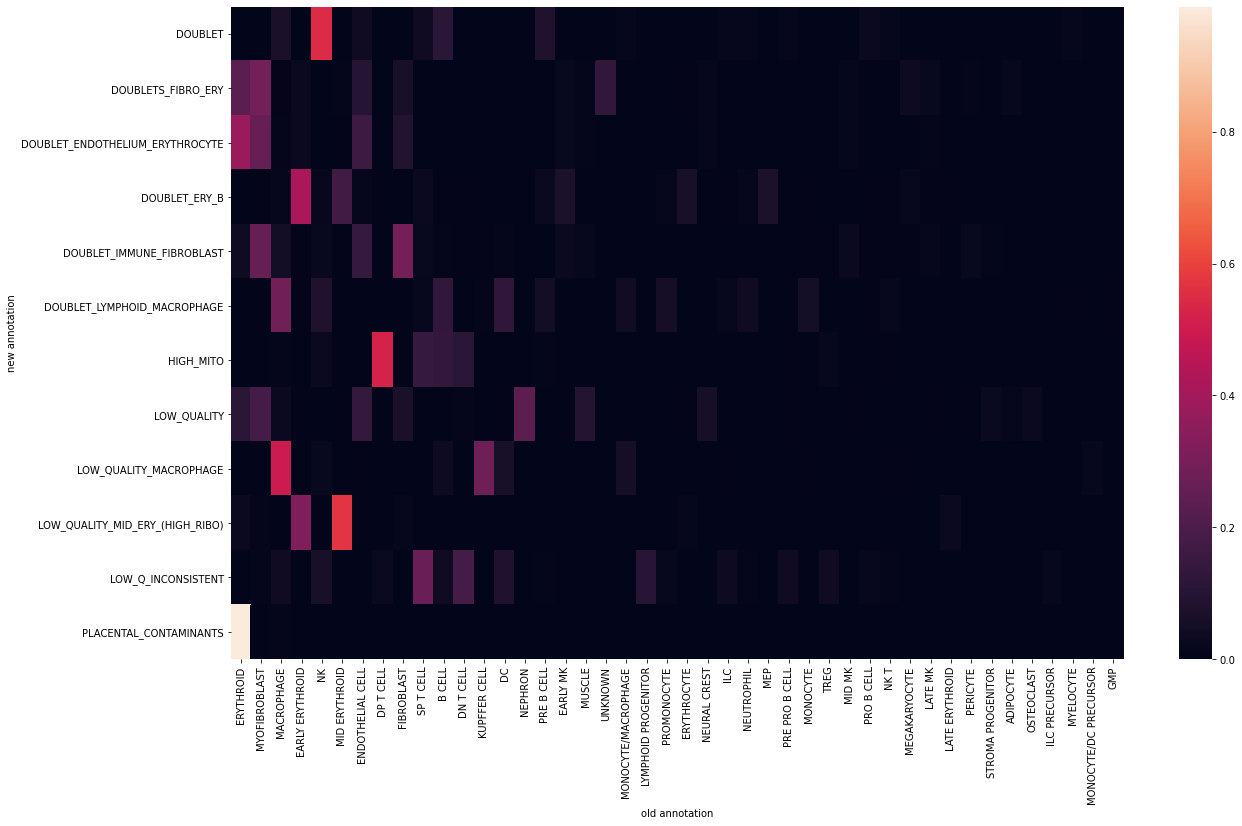

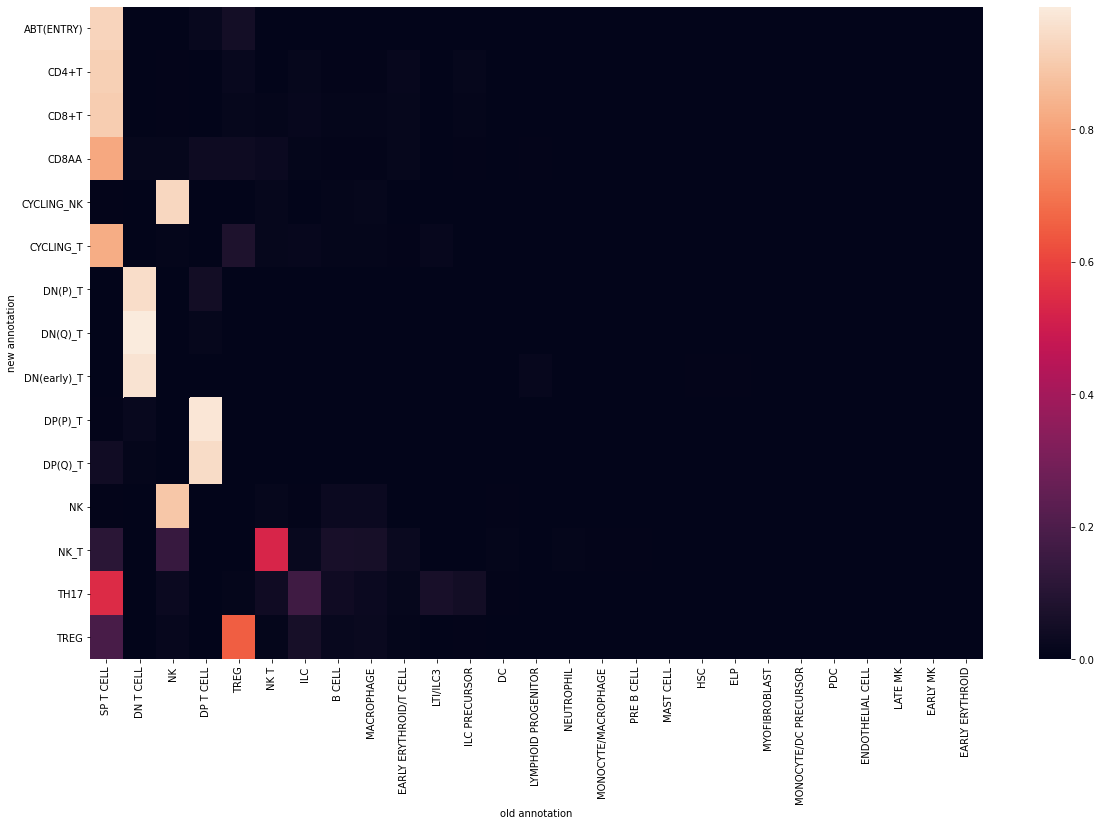

KeyError: "['PRE_DC1'] not in index"

In [326]:
plt.rcParams["figure.figsize"] = [20,12]
for g in anno_groups_dict.keys():
    _plot_old_annotation_confusion(g)
    plt.xlabel("old annotation");
    plt.ylabel("new annotation");
    plt.savefig(figdir + "oldVSnew_{g}.png".format(g="_".join(g.split("/"))), bbox_inches="tight")
    plt.show()

## Organ/age distribution

In [331]:
org_count_df = anno_obs.groupby(["organ", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
org_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
org_count_df.loc[org_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

In [332]:
org_colors = pd.read_csv("../../metadata/organ_colors.csv", index_col=0)

In [334]:
age_count_df = anno_obs.groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
age_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df.loc[age_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

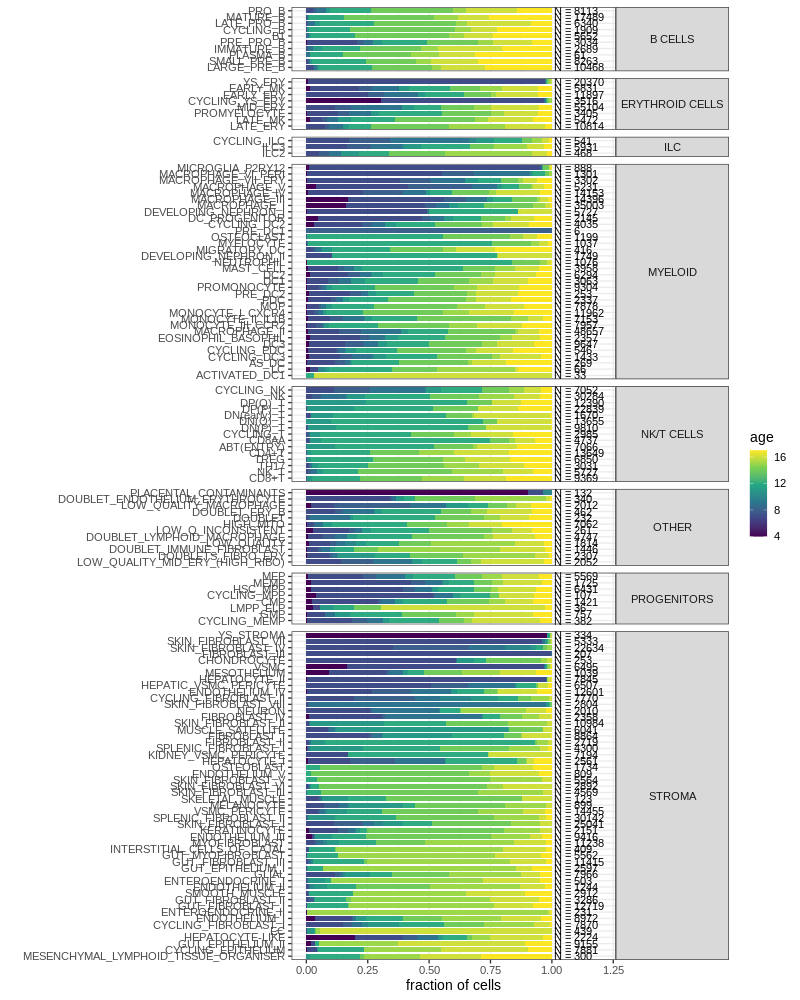

In [337]:
%%R -i age_count_df --i figdir -w 800 -h 1000
age_pl_df <- age_count_df %>%
#     mutate(anno_group= ifelse(anno=="INTERSTITIAL CELLS OF CAJAL", "STROMA", anno_group)) %>%
#     mutate(anno_group= ifelse(anno=="LOW_Q_INCONSISTENT", "OTHER", anno_group)) %>%
    rename(N_cells = file) %>%
    group_by(anno) %>%
    mutate(max_age = age[which.max(N_cells)])  %>% ## At which age there are most cells?
    mutate(min_age = min(age[which(N_cells > 10)]))  %>%
    ungroup() %>%
    arrange(- max_age) %>%
    mutate(anno=factor(anno, levels=unique(anno))) 
    
age_pl_df %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=14) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.2) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0,
              y=1.01, aes(label=paste("N =", N_cells))
             ) +
    ggsave(paste0(figdir, "age_distribution.pdf"), height=20, width=12) +
    ggsave(paste0(figdir, "age_distribution.png"), height=20, width=12) 

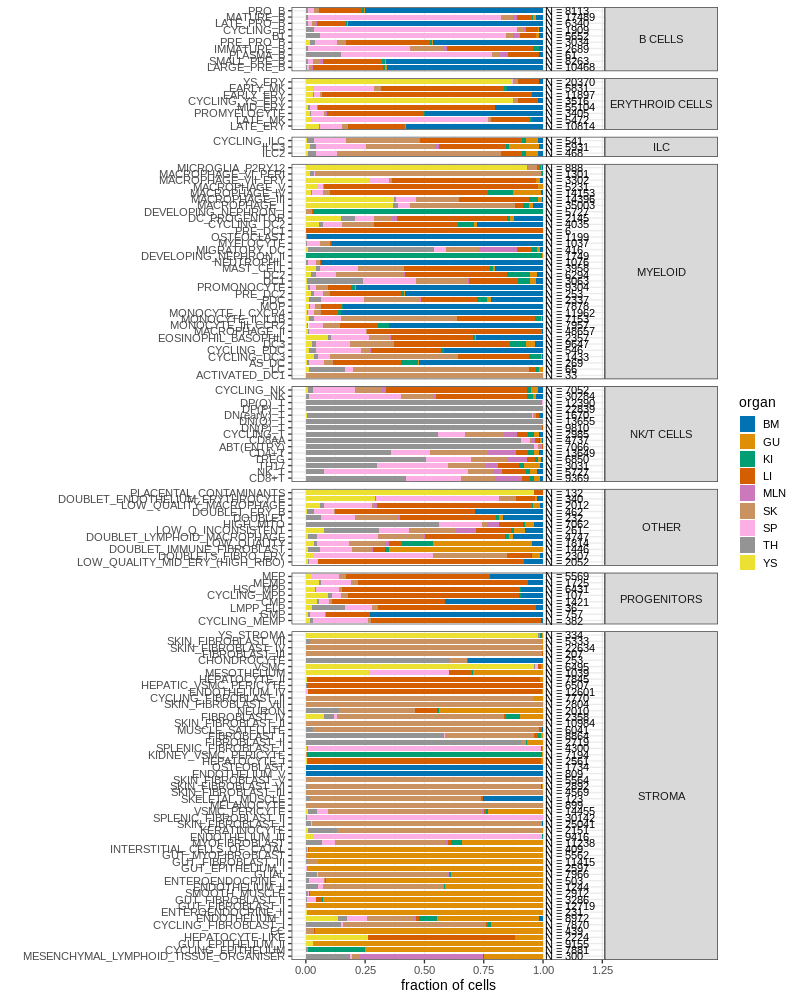

In [339]:
%%R -i org_count_df -i org_colors -i figdir -w 800 -h 1000
org_palette <- setNames(org_colors$color, org_colors$organ)
org_count_df %>%
    mutate(anno_group= ifelse(anno=="INTERSTITIAL CELLS OF CAJAL", "STROMA", anno_group)) %>%
    mutate(anno_group= ifelse(anno=="LOW_Q_INCONSISTENT", "OTHER", anno_group)) %>%
    rename(N_cells = file) %>%
    mutate(anno=factor(anno, levels=levels(age_pl_df$anno))) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=organ) ,position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_manual(values=org_palette) +
    theme_bw(base_size=14) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.2) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0,
              y=1.01, aes(label=paste("N =", N_cells))
             ) +
    ggsave(paste0(figdir, "organ_distribution.pdf"), height=20, width=12) +
    ggsave(paste0(figdir, "organ_distribution.png"), height=20, width=12) 

## Save annotations

In [340]:
anno_obs.to_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.clean.csv".format(t=timestamp))

In [341]:
data_dir + "PAN.A01.v01.entire_data_normalised_log.{t}.full_obs.annotated.clean.csv".format(t=timestamp)

'/nfs/team205/ed6/data/Fetal_immune/PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv'

In [351]:
## Save file for lvl1 groupings 
anno_lvl_0_df = pd.DataFrame([(x,y) for x,y in anno_groups_dict_rev.items()])
anno_lvl_0_df.columns = ['anno_lvl_2_final_clean', "anno_lvl_0"]
anno_lvl_0_df.to_csv('/home/jovyan/mount/gdrive/Pan_fetal/annotations/annotation_terms_20211006.csv')

---

In [93]:
split="MYELOID_V2"
spl_adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))
spl_adata = spl_adata[~spl_adata.obs_names.isin(mat_barcodes)]a

In [95]:
spl_adata.obs['annotation'] = anno_obs_new.loc[spl_adata.obs_names]['anno_lvl_2_final_clean_v3']

Trying to set attribute `.obs` of view, copying.


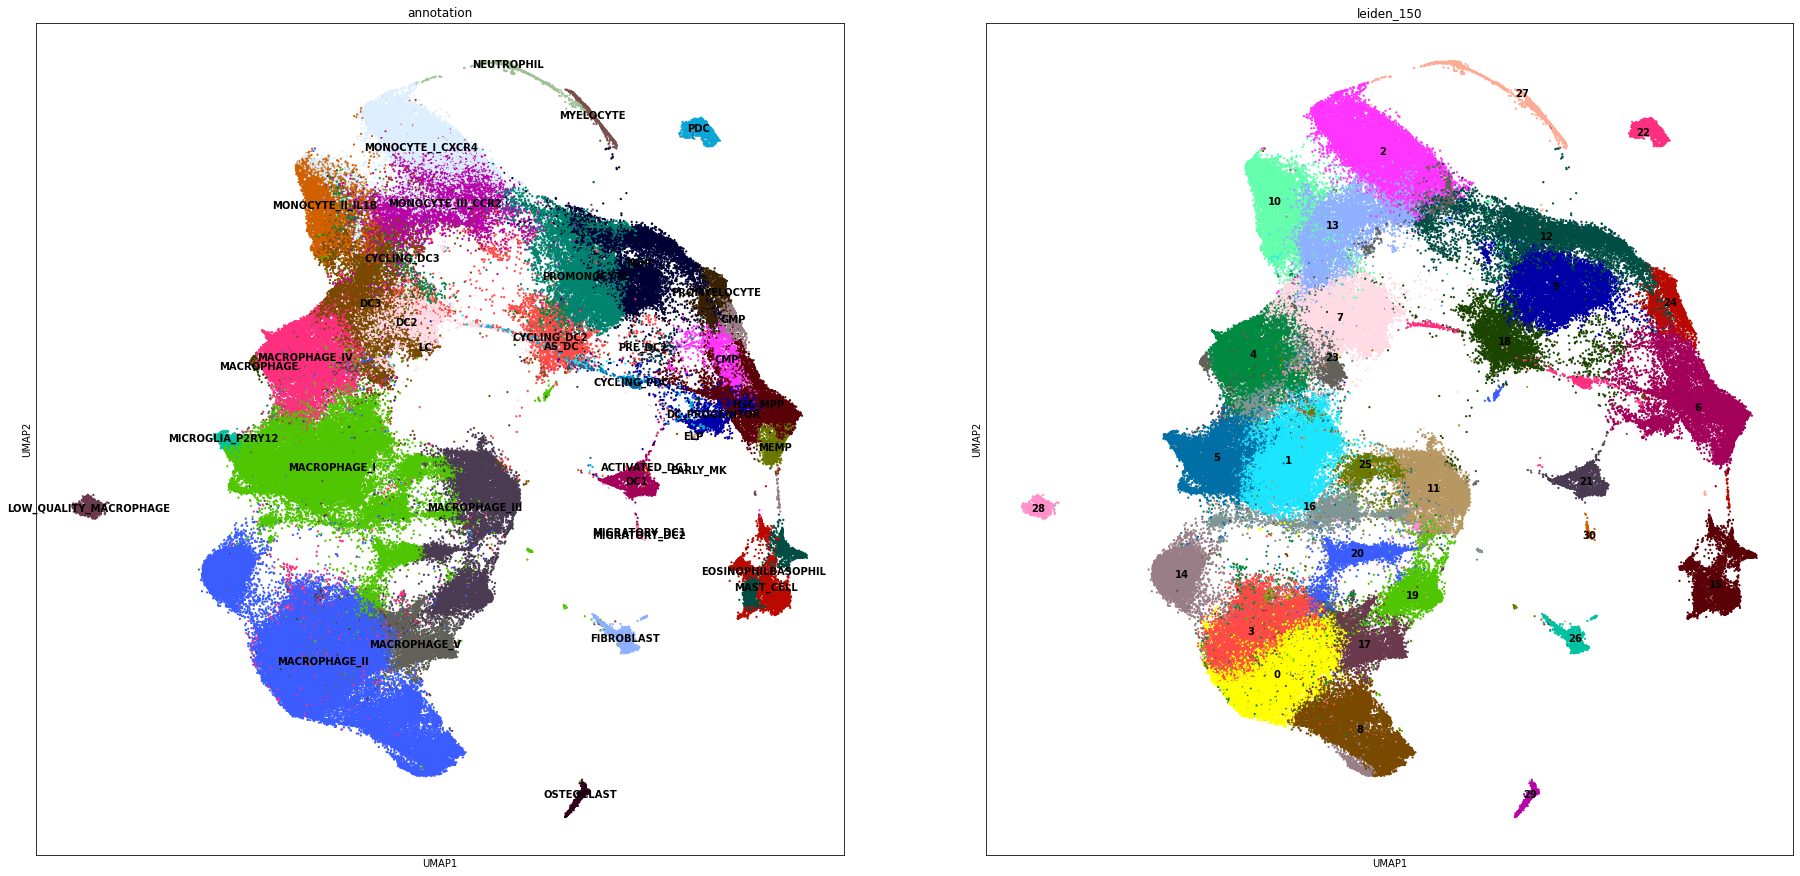

In [119]:
sc.pl.umap(spl_adata, color=['annotation','leiden_150'],size=20, legend_loc="on data")

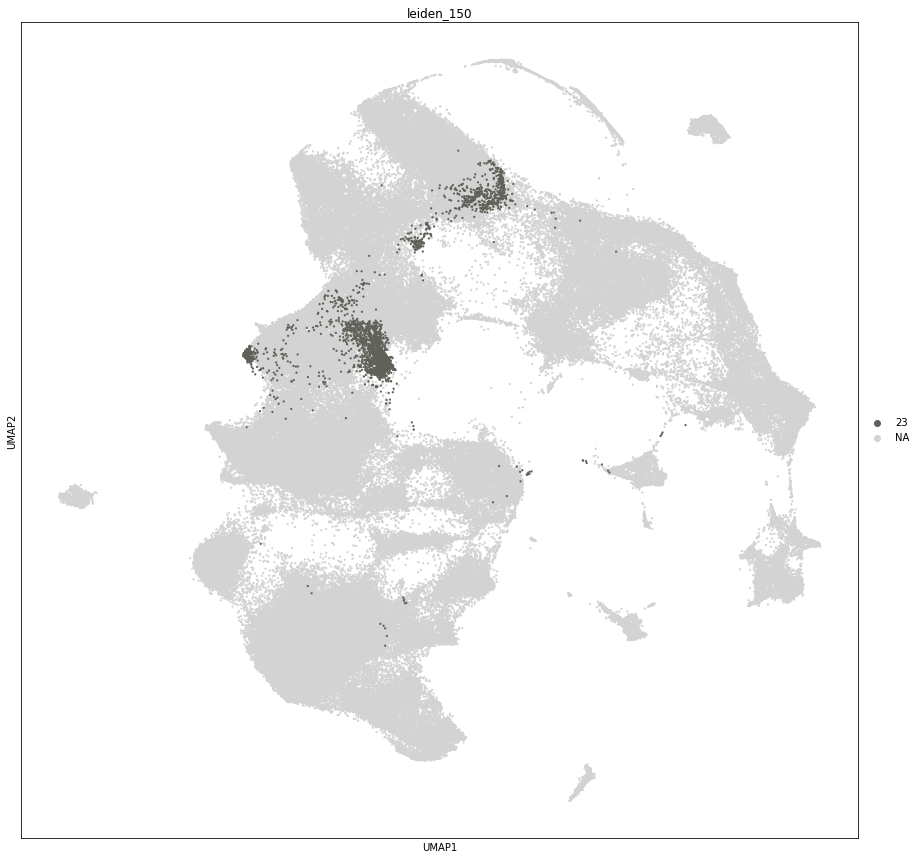

In [115]:
sc.pl.umap(spl_adata, color=['leiden_150'], groups=[23], size=20)

In [117]:
spl_adata.obs[spl_adata.obs["leiden_150"]==23].annotation.value_counts()

DC3                       1266
DC2                        593
MONOCYTE_III_CCR2          370
MACROPHAGE                 238
MONOCYTE_I_CXCR4           140
MACROPHAGE_IV              108
CYCLING_DC2                 43
DC1                         27
DC_PROGENITOR               11
LC                           9
MONOCYTE_II_IL1B             5
AS_DC                        3
MACROPHAGE_V                 2
PDC                          1
PROMYELOCYTE                 1
CYCLING_PDC                  0
HSC_MPP                      0
CYCLING_DC3                  0
CMP                          0
EARLY_MK                     0
ELP                          0
EOSINOPHILBASOPHIL           0
FIBROBLAST                   0
GMP                          0
MACROPHAGE_I                 0
LOW_QUALITY_MACROPHAGE       0
PROMONOCYTE                  0
MACROPHAGE_II                0
MACROPHAGE_III               0
MAST_CELL                    0
MEMP                         0
MICROGLIA_P2RY12             0
MIGRATOR